In [1]:
import geopandas as gpds
import networkx as nx
import time
import random
import matplotlib.pyplot as plt
import json

In [2]:
# Storing data
roads = gpds.read_file('data/sfo_roads.shp')
nodes = gpds.read_file('data/sfo_nodes.shp')

In [3]:
'''
Making shape to NetworkX shortest_path function input format
'''

Edges_Nx = []

for i in range(len(roads)):
    Edge_Nx = (roads.STARTID.iloc[i],roads.ENDID.iloc[i], {'weight':(roads.LENGTH.iloc[i])})
    Edges_Nx.append(Edge_Nx)
    
    
G = nx.Graph()
for i in range(len(roads)):
    G.add_node(i)
G.add_edges_from(Edges_Nx)

In [7]:
def Random_Dijkstra_NetworkX(OutputName):
    '''
    
    This function returns the nodes on the path with QGIS SQL query format.
    Also it generates the geojson output which contains the path nodes as point layer.
    
    '''
    Nodes = []

    # Random nodes selecting
    for i in range(len(nodes)):
        NodeId = str(int(nodes["ID"][i]))

        Nodes.append(NodeId)

    
    index_start = random.randint(0,len(nodes))
    index_finish = random.randint(0,len(nodes))

    Starting_Node = Nodes[index_start]
    Ending_Node = Nodes[index_finish]
    
    
    out_dict = {
    "type": "FeatureCollection",
    "name": OutputName,
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::3857" } },
    "features": [
    ]
    }

    
    try:
        NX_path = nx.shortest_path(G, source=int(Starting_Node), target=int(Ending_Node), weight='weight')
    
        NX_path_SQL = ""

        for j in range(len(NX_path)):
            query = (' "ID" = {} or '.format(NX_path[j]) )
    #           
            NX_path_SQL += query
        
        
        NX_path_SQL = NX_path_SQL[:-4]
        
        
        for i in range(len(NX_path)):
    
    

            X_coord = nodes[nodes["ID"] == NX_path[i]].geometry.item().x #["898840504"]
            Y_coord = nodes[nodes["ID"] == NX_path[i]].geometry.item().y



            point_feature = { "type": "Feature", "properties": { "ID": i }, "geometry": { "type": "Point", "coordinates": [ X_coord, Y_coord ] } }

            out_dict["features"].append(point_feature)
        
        
        OutputString = "results/{}.geojson".format(OutputName) 

        with open(OutputString, 'w') as file:
             file.write(json.dumps(out_dict))

    except:
        NX_path_SQL = "There is no path between {} and {}.".format(Starting_Node,Ending_Node)
        
        
    return NX_path_SQL

    

In [8]:
Random_Dijkstra_NetworkX("path")

'There is no path between 48512938 and 873223901.'

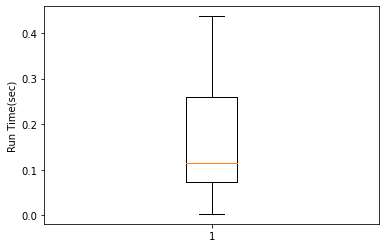

The maximum time sequence for 884132681 node to 48494851 node path. It visited 433 nodes to reach its destination.
The minimum time sequence for 48502307 node to 310090787 node path. It visited 22 nodes to reach its destination.
these two files have been added to the result folder as .geojson format


In [10]:
'''
This cell select N start and finish node. 
It generates two shapefile for one of them is minimum time cost path the other one is maximum time cost weight.

'''


N = 30 #It related with how many route will generated

Nodes = []

# Random nodes selecting
for i in range(len(nodes)):
    NodeId = str(int(nodes["ID"][i]))

    Nodes.append(NodeId)

Random_Edges_Dijkstra_Start = []
Random_Edges_Dijkstra_Finish = []

for i in range(N):
    index_start = random.randint(0,len(nodes))
    index_finish = random.randint(0,len(nodes))

    Random_Edges_Dijkstra_Start.append(Nodes[index_start])
    Random_Edges_Dijkstra_Finish.append(Nodes[index_finish])
    
Time_List = []
min_time = 999999999999999999999999999
min_path = []
max_time = 0

Count_No_path = 0

for i in range (len(Random_Edges_Dijkstra_Start)):
    
    try:
        Start_Nx = time.time()
        NX_path = nx.shortest_path(G, source=int(Random_Edges_Dijkstra_Start[i]), target=int(Random_Edges_Dijkstra_Finish[(i)]), weight='weight')
        Finish_Nx = time.time()
        Diff_Nx = Finish_Nx - Start_Nx

        Time_List.append(Diff_Nx)
        
        

        if (Diff_Nx < min_time):
            min_time = Diff_Nx
            min_path = NX_path
        
        if (Diff_Nx > max_time):
            max_time = Diff_Nx
            max_path = NX_path
            
            
    except:
        Count_No_path += 1



## Generating the geojson files for max and min path



# Generating the max path

out_dict_max = {
"type": "FeatureCollection",
"name": "Max_Path",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::3857" } },
"features": []
}

for i in range(len(max_path)):
    
    X_coord = nodes[nodes["ID"] == max_path[i]].geometry.item().x 
    Y_coord = nodes[nodes["ID"] == max_path[i]].geometry.item().y

    point_feature = { "type": "Feature", "properties": { "ID": i }, "geometry": { "type": "Point", "coordinates": [ X_coord, Y_coord ] } }
    
    out_dict_max["features"].append(point_feature)
    


with open("results/max_path.geojson", 'w') as file:
    file.write(json.dumps(out_dict_max)) 
    
# Generating the min path

out_dict_min = {
"type": "FeatureCollection",
"name": "Min_Path",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::3857" } },
"features": []
}

for i in range(len(min_path)):
    
    X_coord = nodes[nodes["ID"] == min_path[i]].geometry.item().x 
    Y_coord = nodes[nodes["ID"] == min_path[i]].geometry.item().y

    point_feature = { "type": "Feature", "properties": { "ID": i }, "geometry": { "type": "Point", "coordinates": [ X_coord, Y_coord ] } }
    
    out_dict_min["features"].append(point_feature)
    


with open("results/min_path.geojson", 'w') as file:
    file.write(json.dumps(out_dict_min))


# Creating plot
plt.boxplot(Time_List)


plt.ylabel("Run Time(sec)")


# show plot
plt.show()


print("The maximum time sequence for {} node to {} node path. It visited {} nodes to reach its destination.".format(max_path[0], max_path[-1], len(max_path)))
print("The minimum time sequence for {} node to {} node path. It visited {} nodes to reach its destination.".format(min_path[0], min_path[-1], len(min_path)))
print("these two files have been added to the result folder as .geojson format")
